## 데이터 전처리 및 EDA - 서울시 행정동별 거주인구 

In [1]:
"""NO 필드명 필드내용 비 고
1 STD_YM 기준년월
2 ADMI_CD 행정동코드 8자리
3 ADMI_NM 행정동명
4 SEXDSTN_CD 성별_코드 (1 : 남성, 2 : 여성)
5 AGRDE_CD 연령대_코드
6 RSPOP_CNT 거주인구_수
7 CTY_NM 시군구명"""

'NO 필드명 필드내용 비 고\n1 STD_YM 기준년월\n2 ADMI_CD 행정동코드 8자리\n3 ADMI_NM 행정동명\n4 SEXDSTN_CD 성별_코드 (1 : 남성, 2 : 여성)\n5 AGRDE_CD 연령대_코드\n6 RSPOP_CNT 거주인구_수\n7 CTY_NM 시군구명'

In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns

from matplotlib import font_manager
f_path = "C:\Windows\Fonts\Malgun.ttf"
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family='Malgun Gothic')

sns.set_style('whitegrid', {'font.family':'Malgun Gothic'})

### 데이터 로드 및 불필요한 특수문자(백틱) 제거

In [10]:
data = pd.read_csv('./data/서울시 행정동별 거주인구.csv')
data.shape

(17724, 7)

In [11]:
# 컬럼명에서 백틱 제외
data.columns =[re.sub('[`]', '', i) for i in data.columns.to_list()]

# 본문에서 백틱 제외
for column in data.columns:
    data[column] = data[column].apply(lambda x : re.sub('[`]', '', x))

data.head(2)

,STD_YM,ADMI_CD,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT,CTY_NM
0,202306,11290600,안암동,1,0004,174,성북구
1,202306,11230720,휘경1동,1,0004,326,동대문구


In [12]:
# 거주인구 integer로 형 변환
data['RSPOP_CNT'] = data['RSPOP_CNT'].astype('int')

# 강남구와 관악구에 동일한 행정동 조회 -> 행정동(구이름)으로 변경 필요
data[data['ADMI_NM'] == '신사동'].head(2)

,STD_YM,ADMI_CD,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT,CTY_NM
107,202306,11620685,신사동,1,0004,258,관악구
343,202306,11680510,신사동,1,0004,358,강남구


In [13]:
# 강남구 신사동 -> 신사동(관악구), 신사동(강남구)로 변환
for i in data[(data['ADMI_NM'] == '신사동') & (data['CTY_NM'] == '관악구')]['ADMI_NM'].index:
    data.at[i, 'ADMI_NM'] = '신사동(관악구)'

for i in data[(data['ADMI_NM'] == '신사동') & (data['CTY_NM'] == '강남구')]['ADMI_NM'].index:
    data.at[i, 'ADMI_NM'] = '신사동(강남구)'
data[data['ADMI_NM'] == '신사동(강남구)'].head(2)

,STD_YM,ADMI_CD,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT,CTY_NM
343,202306,11680510,신사동(강남구),1,0004,358,강남구
765,202306,11680510,신사동(강남구),1,0509,514,강남구


In [14]:
# 행정동명 개수 구하기 -> 426개 차이가 있음
len(data['ADMI_NM'].unique())

422

In [17]:
# 결측치가 있는 행정동 이름 가져오기
test = pd.read_csv('./data_to_preprocess/서울시_행정동_코드_행안부(8자리)_수정.csv', usecols=['행정동명'])
full = test['행정동명'].to_list()
not_full = data['ADMI_NM'].to_list()

for i in full:
    if i not in not_full:
        print(i)

항동
신사동
신사동
개포3동
상일1동
상일2동


In [18]:
# 행정동 코드로 결측치가 있는 행정동 찾아보기
test = pd.read_csv('./data_to_preprocess/서울시_행정동_코드_행안부(8자리)_수정.csv')
full = test['행정동코드8'].to_list()
not_full = data['ADMI_CD'].astype('int').to_list()

for i in full:
    if i not in not_full:
        print(f"{i} : {test[test['행정동코드8'] == i]['행정동명']}")

11530800 : 275    항동
Name: 행정동명, dtype: object
11680675 : 374    개포3동
Name: 행정동명, dtype: object
11740525 : 408    상일1동
Name: 행정동명, dtype: object
11740526 : 409    상일2동
Name: 행정동명, dtype: object


구청에서 획득한 강남구, 강동구, 구로구 인구정보로 대치하기

- 빅캠 데이터의 결측치인 항동, 개포3동, 상일1동, 상일2동은 해당 동이 포함된 구의 구청 인구 데이터로 대치 (2023년 6월 기준)

In [19]:
import os
os.listdir('./빅캠 거주인구 결측치 보완 데이터/')[1:]

['인구 및 세대현황_강남구.xlsx', '인구 및 세대현황_강동구.xlsx', '인구 및 세대현황_구로구.xlsx']

In [22]:
# 데이터 로드
guro = pd.read_excel(f'./빅캠 거주인구 결측치 보완 데이터/인구 및 세대현황_구로구.xlsx', usecols=[1, 3], names = ['행정동명', '인구수'], thousands=',')
gangnam = pd.read_excel(f'./빅캠 거주인구 결측치 보완 데이터/인구 및 세대현황_강남구.xlsx', usecols=[1, 3], names = ['행정동명', '인구수'], thousands=',')
gangdong = pd.read_excel(f'./빅캠 거주인구 결측치 보완 데이터/인구 및 세대현황_강동구.xlsx', usecols=[1, 3], names = ['행정동명', '인구수'], thousands=',')

# 필요한 행만 남기기
guro = guro.iloc[6:, :]
gangnam = gangnam.iloc[6:, :]
gangdong = gangdong.iloc[6:, :]

# 구로제1동 -> 구로1동 ('제' 제거)
# 정규식을 사용하여 '동네이름'+'제'+'숫자'+'동'를 '동네이름'+'숫자'+'동'으로 변경
guro['행정동명'] = guro['행정동명'].apply(lambda x: re.sub(r'제(\d+)동', r'\1동', x) if '제' in x else x)
gangnam['행정동명'] = gangnam['행정동명'].apply(lambda x: re.sub(r'제(\d+)동', r'\1동', x) if '제' in x else x)
gangdong['행정동명'] = gangdong['행정동명'].apply(lambda x: re.sub(r'제(\d+)동', r'\1동', x) if '제' in x else x)

In [23]:
# 상이한 행정동명 재확인
for i in guro['행정동명'].unique():
    if i not in data[data['CTY_NM'] == '구로구']['ADMI_NM'].unique():
        print(f"{i} : {guro[guro['행정동명'] == i]['행정동명']}")

for i in gangnam['행정동명'].unique():
    if i not in data[data['CTY_NM'] == '강남구']['ADMI_NM'].unique():
        print(f"{i} : {gangnam[gangnam['행정동명'] == i]['행정동명']}")

for i in gangdong['행정동명'].unique():
    if i not in data[data['CTY_NM'] == '강동구']['ADMI_NM'].unique():
        print(f"{i} : {gangdong[gangdong['행정동명'] == i]['행정동명']}")

항동 : 21    항동
Name: 행정동명, dtype: object
신사동 : 6    신사동
Name: 행정동명, dtype: object
개포3동 : 22    개포3동
Name: 행정동명, dtype: object
상일1동 : 7    상일1동
Name: 행정동명, dtype: object
상일2동 : 8    상일2동
Name: 행정동명, dtype: object


In [26]:
# 구로구, 강남구, 강동구 합치고 신사동 제외하기
data_to_add = pd.concat([guro, gangnam, gangdong])
data_to_add = data_to_add[~(data_to_add['행정동명'] == '신사동')]

빅캠 데이터를 동으로 그룹핑하고 전체 인구수 합계 내기

In [28]:
filtered_data = data.groupby('ADMI_NM')['RSPOP_CNT'].sum().to_frame()
filtered_data.reset_index(inplace=True)
filtered_data.rename(columns={'ADMI_NM': '행정동명', 'RSPOP_CNT': '인구수'}, inplace=True)
filtered_data.shape

(422, 2)

In [29]:
merged_data = pd.merge(filtered_data, data_to_add, left_on='행정동명', right_on='행정동명', how='outer')
merged_data.fillna(0, inplace=True)
merged_data

,행정동명,인구수_x,인구수_y
0,가락1동,55068.0,0
1,가락2동,62654.0,0
2,가락본동,50842.0,0
3,가리봉동,17864.0,8932
4,가산동,49292.0,0
...,...,...,...
421,흑석동,59748.0,0
422,항동,0.0,16415
423,개포3동,0.0,17069
424,상일1동,0.0,39283


In [30]:
final_data = merged_data.copy()
for i in merged_data.index:
    if (final_data.at[i, '인구수_y'] == 0) & (final_data.at[i, '인구수_x'] > 0):
        final_data.at[i, '인구수'] = final_data.at[i, '인구수_x']  
    if (final_data.at[i, '인구수_x'] == 0) & (final_data.at[i, '인구수_y'] != 0):
        final_data.at[i, '인구수'] = final_data.at[i, '인구수_y']
    if (final_data.at[i, '인구수_y'] != 0) & (final_data.at[i, '인구수_x'] != 0):
        final_data.at[i, '인구수'] = final_data.at[i, '인구수_y'] 

In [31]:
final_data[['행정동명', '인구수']].to_csv('./preprocessed_data/행정동별_거주인구.csv', index=None)

In [281]:
# # 강남구, 강동구, 구로구에 
# merged_data = filtered_data.copy()
# for i in merged_data['행정동명'].index:
#     for j in guro['행정동명'].index:
#         if merged_data.at[i, '행정동명'] == guro.at[j, '행정동명']:
#             merged_data.at[i, '인구수'] = guro.at[j, '인구수']

# for i in merged_data['행정동명'].index:
#     for j in gangnam['행정동명'].index:
#         if merged_data.at[i, '행정동명'] == gangnam.at[j, '행정동명']:
#             merged_data.at[i, '인구수'] = gangnam.at[j, '인구수']

# for i in merged_data['행정동명'].index:
#     for j in gangdong['행정동명'].index:
#         if merged_data.at[i, '행정동명'] == gangdong.at[j, '행정동명']:
#             merged_data.at[i, '인구수'] = gangdong.at[j, '인구수']

--- 
행정동을 합치는 작업은 하지 않기로 결정함!

### 행정동, 법정동 전처리 
화곡 1동, 화곡 2동 -> 화곡동으로 바꾸고 인구 합치기

In [206]:
# 동이름에서 숫자 제외하기
kor_str = [re.sub(r"[^ㄱ-ㅣ가-힣\s]", "",i )for i in data['ADMI_NM']]
data['ADMI_NM'] = kor_str

In [207]:
# 숫자가 제외된 동이름으로 묶고, 인구수 집계 
df = data.groupby(['CTY_NM', 'ADMI_NM','SEXDSTN_CD', 'AGRDE_CD'])['RSPOP_CNT'].sum().to_frame()
df.reset_index(inplace=True)
df

,CTY_NM,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT
0,강남구,개포동,1,0004,2232
1,강남구,개포동,1,0509,3392
2,강남구,개포동,1,1014,3984
3,강남구,개포동,1,1519,3710
4,강남구,개포동,1,2024,3880
...,...,...,...,...,...
10201,중랑구,중화동,2,8084,1390
10202,중랑구,중화동,2,8589,684
10203,중랑구,중화동,2,9094,188
10204,중랑구,중화동,2,9599,46


In [209]:
print('행정구역 동 통합 이후 개수:', len(df['ADMI_NM'].unique()), '개')

행정구역 동 통합 이후 개수: 240 개


---

In [32]:
# 막대 그래프 그리는 함수 설정
# def plot_bar(data, xlabel, ylabel, title):
#     plt.rc('font', family='Malgun Gothic')
#     plt.bar(x=data.index, height=data.values)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.show()

def plot_bar(data, xlabel, ylabel, title, figsize=(10, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=data.index, y=data.values, palette="Set2")
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(title)
    plt.xticks(rotation=45)  
    plt.show()

def plot_bar_with_hue(data, xlabel, ylabel, title, x, y, hue, figsize=(10, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    data = data.to_frame()
    data.reset_index(inplace=True)
    sns.barplot(data, x=x, y=y, palette="Set2", hue=hue)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(title)
    plt.xticks(rotation=45)  
    plt.show()

In [ ]:
# 구별 거주 인구 합계(내림차순)
df.groupby('CTY_NM').sum()['RSPOP_CNT'].sort_values(ascending=False).head(10)

In [34]:
df

,CTY_NM,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT
0,강남구,개포동,1,0004,2232
1,강남구,개포동,1,0509,3392
2,강남구,개포동,1,1014,3984
3,강남구,개포동,1,1519,3710
4,강남구,개포동,1,2024,3880
...,...,...,...,...,...
10201,중랑구,중화동,2,8084,1390
10202,중랑구,중화동,2,8589,684
10203,중랑구,중화동,2,9094,188
10204,중랑구,중화동,2,9599,46


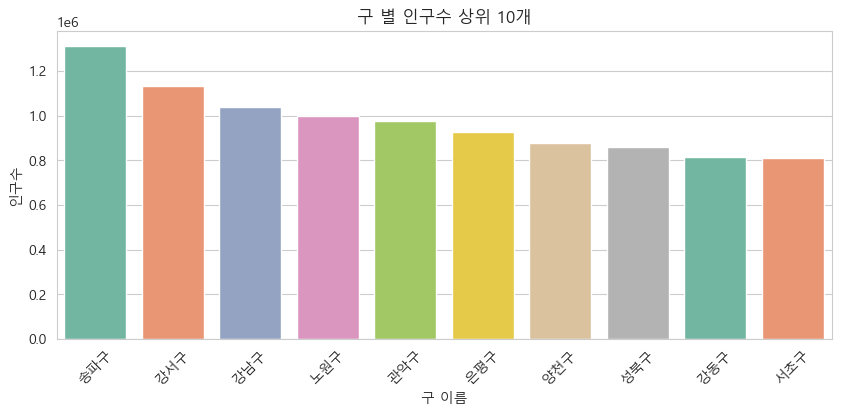

In [68]:
plot_bar(df.groupby('CTY_NM').sum()['RSPOP_CNT'].sort_values(ascending=False).head(10), '구 이름', '인구수', '구 별 인구수 상위 10개')

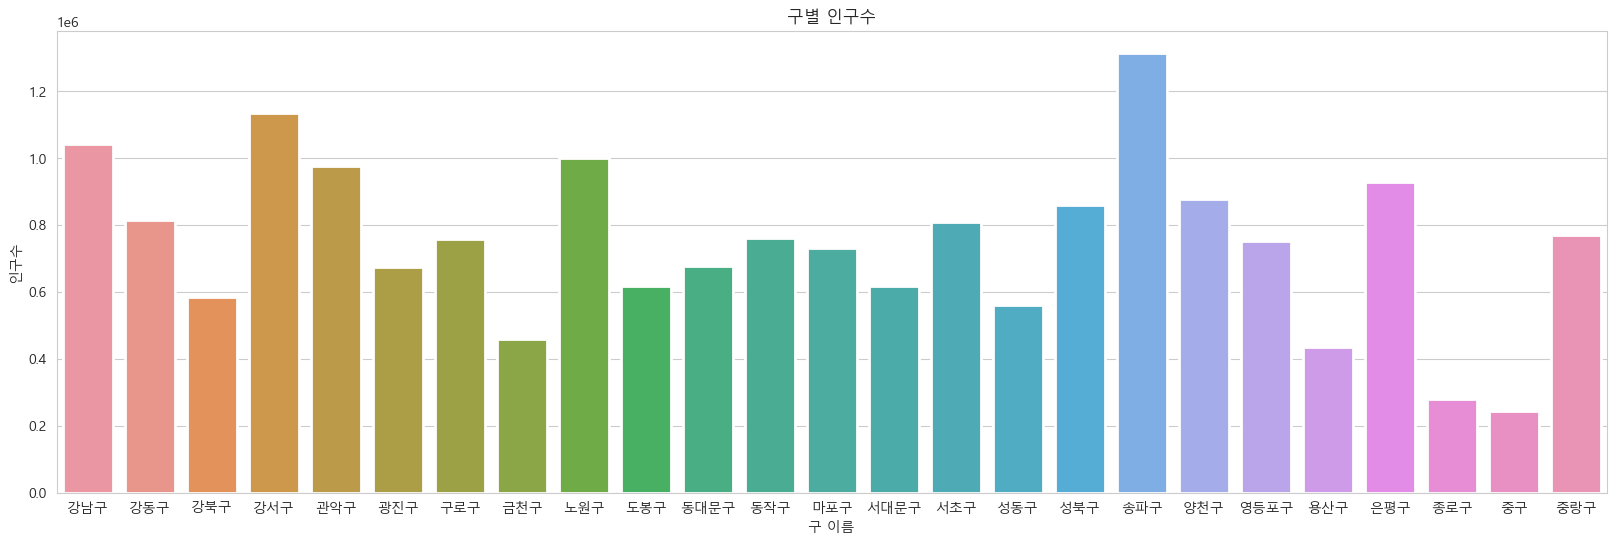

In [148]:
fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the figsize as needed
sns.barplot(data=df, x="CTY_NM", y="RSPOP_CNT", estimator=sum, errorbar=None, linewidth=2, ax=ax)
ax.set(xlabel="구 이름", ylabel="인구수", title="구별 인구수")
plt.show()


In [16]:
# 동별 거주 인구 합계(내림차순)
df.groupby(['CTY_NM', 'ADMI_NM']).sum()['RSPOP_CNT'].sort_values(ascending=False).head(10)

CTY_NM  ADMI_NM
노원구     상계동        393652
양천구     신정동        346162
강서구     화곡동        317708
양천구     목동         291540
동작구     상도동        248214
양천구     신월동        239004
송파구     잠실동        232176
도봉구     창동         231768
구로구     구로동        230018
서초구     서초동        218956
Name: RSPOP_CNT, dtype: int32

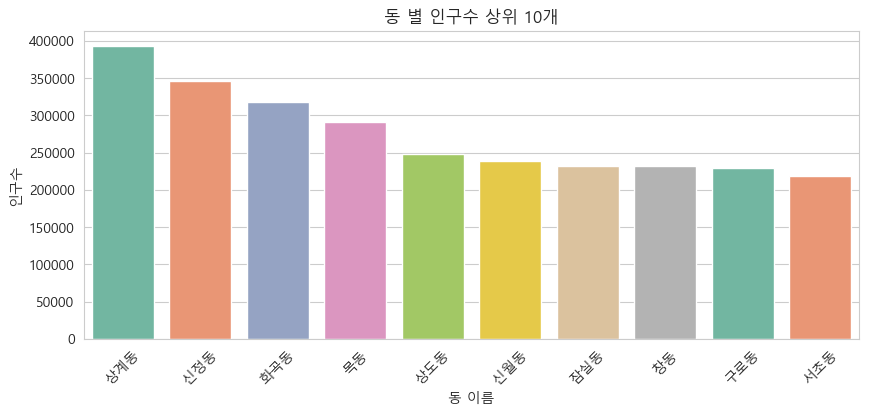

In [59]:
plot_bar(df.groupby(['ADMI_NM']).sum()['RSPOP_CNT'].sort_values(ascending=False).head(10), '동 이름', '인구수', '동 별 인구수 상위 10개')

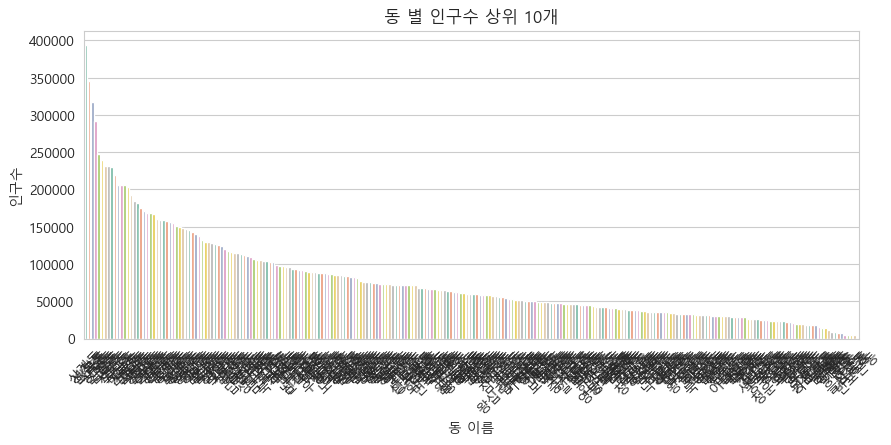

In [151]:
plot_bar(df.groupby(['ADMI_NM']).sum()['RSPOP_CNT'].sort_values(ascending=False), '동 이름', '인구수', '동 별 인구수 상위 10개')

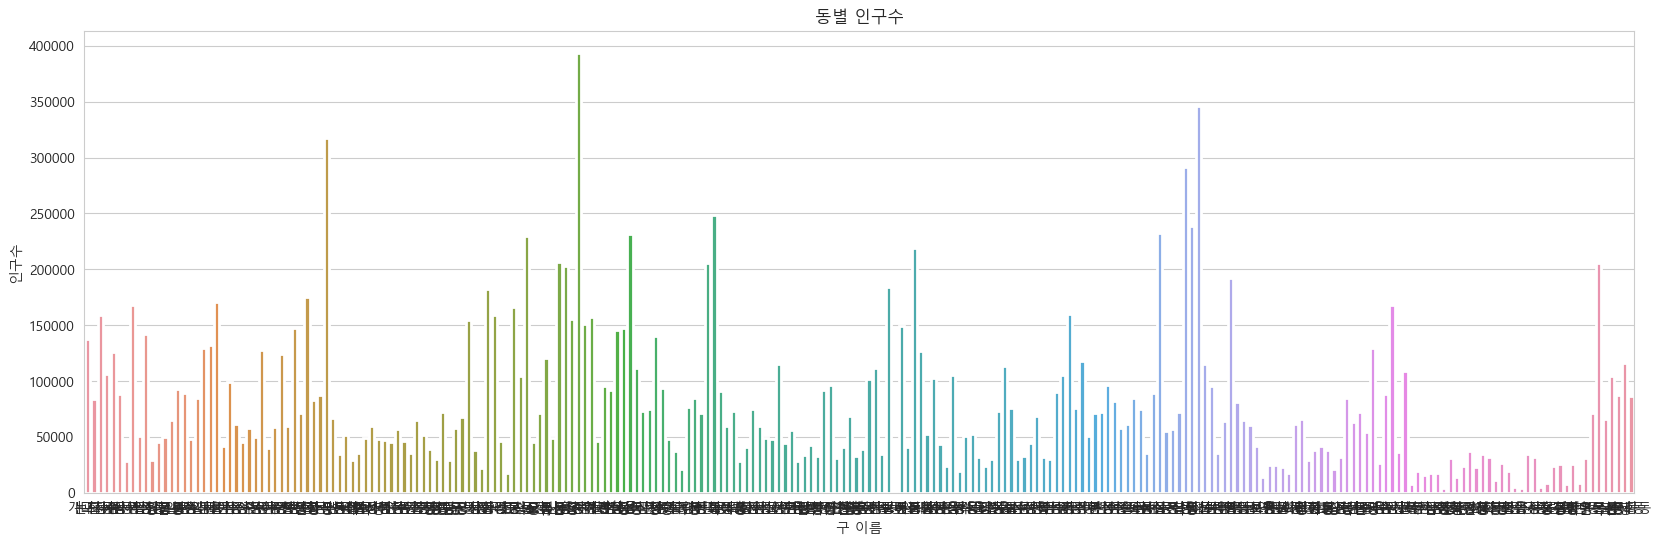

In [150]:
fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the figsize as needed
sns.barplot(data=df, x="ADMI_NM", y="RSPOP_CNT", estimator=sum, errorbar=None, linewidth=2, ax=ax)
ax.set(xlabel="구 이름", ylabel="인구수", title="동별 인구수")
plt.show()

In [10]:
# 동별 거주 인구 합계(내림차순)_ 동 통합 이전
data.groupby(['CTY_NM', 'ADMI_NM']).sum()['RSPOP_CNT'].sort_values(ascending=False).head(10)

CTY_NM  ADMI_NM
은평구     진관동        109356
강서구     화곡1동       103224
양천구     신정3동       100026
금천구     독산1동        92664
강동구     길동          89616
송파구     위례동         89344
동작구     상도1동        88674
은평구     역촌동         88564
강남구     세곡동         88410
강서구     우장산동        87492
Name: RSPOP_CNT, dtype: int32

In [12]:
data.groupby(['CTY_NM', 'ADMI_NM']).sum()['RSPOP_CNT'].sort_values(ascending=False).to_csv('people_test.csv')

성별로 살펴 보기

In [134]:
df.groupby(['CTY_NM', 'ADMI_NM', 'SEXDSTN_CD']).sum()['RSPOP_CNT'].sort_values(ascending=False).head(10).to_frame()

RSPOP_CNT
CTY_NM ADMI_NM SEXDSTN_CD           
노원구    상계동     2              205370
               1              188282
양천구    신정동     2              178268
               1              167894
강서구    화곡동     2              164244
               1              153464
양천구    목동      2              149920
               1              141620
동작구    상도동     2              128518
송파구    잠실동     2              121700

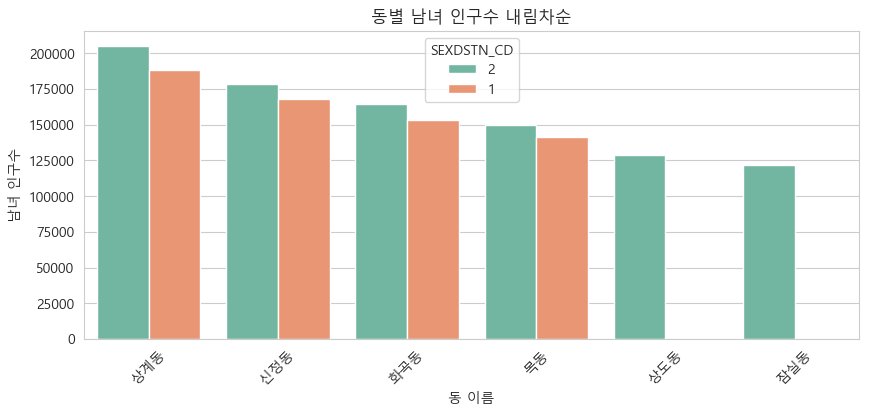

In [135]:
plot_bar_with_hue(
    df.groupby(['CTY_NM', 'ADMI_NM', 'SEXDSTN_CD']).sum()['RSPOP_CNT'].sort_values(ascending=False).head(10), 
    "동 이름", "남녀 인구수", "동별 남녀 인구수 내림차순", 
    'ADMI_NM','RSPOP_CNT', 'SEXDSTN_CD' )

In [66]:
# 동별 거주 인구 남성 인구 합계(내림차순)
df[df['SEXDSTN_CD'] == '1'].groupby(['CTY_NM', 'ADMI_NM'])['RSPOP_CNT'].sum().sort_values(ascending=False).head(10)

CTY_NM  ADMI_NM
노원구     상계동        188282
양천구     신정동        167894
강서구     화곡동        153464
양천구     목동         141620
동작구     상도동        119696
양천구     신월동        118832
구로구     구로동        113768
도봉구     창동         111756
송파구     잠실동        110476
서초구     서초동        105018
Name: RSPOP_CNT, dtype: int32

In [20]:
# 동별 거주 인구 남성 인구 합계(내림차순)_동 통합 이전
data[data['SEXDSTN_CD'] == '1'].groupby(['CTY_NM', 'ADMI_NM'])['RSPOP_CNT'].sum().sort_values(ascending=False).head(10)

CTY_NM  ADMI_NM
노원구     상계동        188282
양천구     신정동        167894
강서구     화곡동        153464
양천구     목동         141620
동작구     상도동        119696
양천구     신월동        118832
구로구     구로동        113768
도봉구     창동         111756
송파구     잠실동        110476
서초구     서초동        105018
Name: RSPOP_CNT, dtype: int32

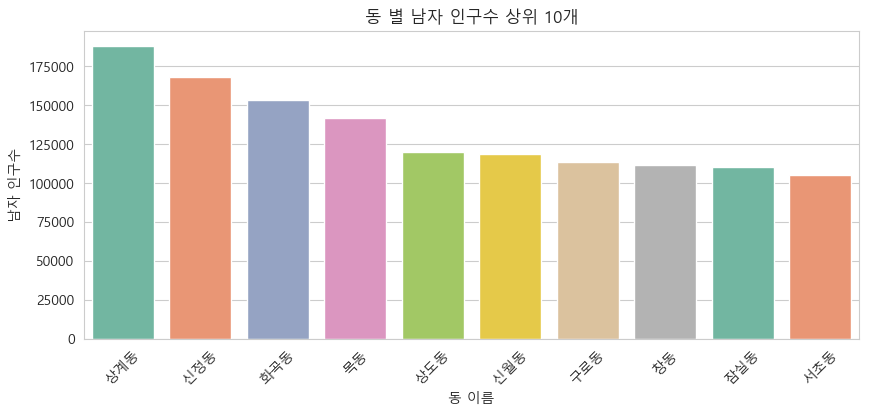

In [60]:
plot_bar(df[df['SEXDSTN_CD'] == '1'].groupby(['ADMI_NM'])['RSPOP_CNT'].sum().sort_values(ascending=False).head(10), '동 이름', '남자 인구수', '동 별 남자 인구수 상위 10개')

In [22]:
# 동별 거주 인구 여성 인구 합계
df[df['SEXDSTN_CD'] == '2'].groupby(['CTY_NM', 'ADMI_NM'])['RSPOP_CNT'].sum().sort_values(ascending=False).nlargest(10)

CTY_NM  ADMI_NM
노원구     상계동        205370
양천구     신정동        178268
강서구     화곡동        164244
양천구     목동         149920
동작구     상도동        128518
송파구     잠실동        121700
양천구     신월동        120172
도봉구     창동         120012
구로구     구로동        116250
서초구     서초동        113938
Name: RSPOP_CNT, dtype: int32

In [23]:
# 동별 거주 인구 여성 인구 합계
data[data['SEXDSTN_CD'] == '2'].groupby(['CTY_NM', 'ADMI_NM'])['RSPOP_CNT'].sum().sort_values(ascending=False).nlargest(10)

CTY_NM  ADMI_NM
노원구     상계동        205370
양천구     신정동        178268
강서구     화곡동        164244
양천구     목동         149920
동작구     상도동        128518
송파구     잠실동        121700
양천구     신월동        120172
도봉구     창동         120012
구로구     구로동        116250
서초구     서초동        113938
Name: RSPOP_CNT, dtype: int32

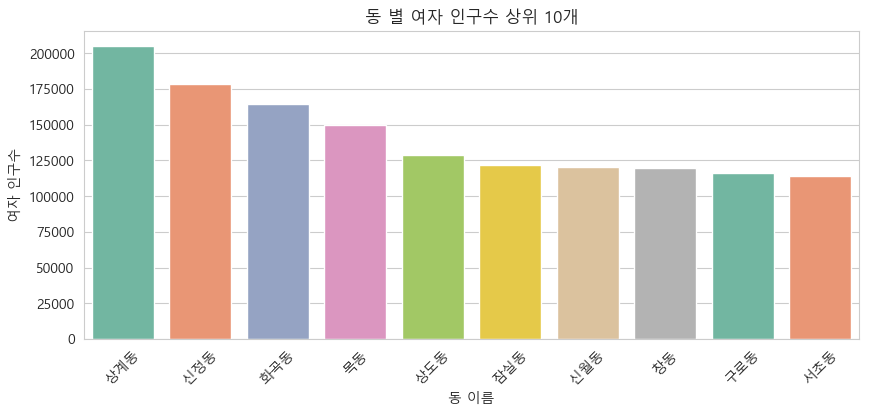

In [61]:
plot_bar(df[df['SEXDSTN_CD'] == '2'].groupby(['ADMI_NM'])['RSPOP_CNT'].sum().sort_values(ascending=False).head(10), '동 이름', '여자 인구수', '동 별 여자 인구수 상위 10개')

연령대별로 살펴 보기

In [251]:
# 0004, 0509 -> 10대 미만, 1014, 1519 -> 10대로 바꾸기
category_mapping = {}
category = ['0대', '10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '기타']
for idx, i in enumerate(df['AGRDE_CD'].unique()):
    for idx2, j in enumerate(category):
        if idx // 2 == idx2:
            category_mapping[i] = j

In [252]:
df['AGRDE_CD'].unique()

array(['0004', '0509', '1014', '1519', '2024', '2529', '3034', '3539',
       '4044', '4549', '5054', '5559', '6064', '6569', '7074', '7579',
       '8084', '8589', '9094', '9599', 'I00'], dtype=object)

In [253]:
df_age = df.copy()

In [254]:
df_age['AGRDE_CD'] = df_age['AGRDE_CD'].map(category_mapping)

In [255]:
df_age

,CTY_NM,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT
0,강남구,개포동,1,0대,2232
1,강남구,개포동,1,0대,3392
2,강남구,개포동,1,10대,3984
3,강남구,개포동,1,10대,3710
4,강남구,개포동,1,20대,3880
...,...,...,...,...,...
10201,중랑구,중화동,2,80대,1390
10202,중랑구,중화동,2,80대,684
10203,중랑구,중화동,2,90대,188
10204,중랑구,중화동,2,90대,46


In [257]:
df_age.groupby(['CTY_NM', 'ADMI_NM', 'SEXDSTN_CD', 'AGRDE_CD']).sum()

RSPOP_CNT
CTY_NM ADMI_NM SEXDSTN_CD AGRDE_CD           
강남구    개포동     1          0대             5624
                          10대            7694
                          20대            8024
                          30대            8848
                          40대           11006
...                                       ...
중랑구    중화동     2          60대            7706
                          70대            4150
                          80대            2074
                          90대             234
                          기타                4

[5346 rows x 1 columns]